<h1>Churn Project for Udacity Data Science Nano Degree Program</h1>

This project is the first assignement for the Udacity Nano Degree in Data Science Program. In this assignment I must identify a dataset to explore, pose at least 3 questions, and then answer those questions using the data. I have decided to work with some telecom data available on <a href="https://www.kaggle.com/radmirzosimov/telecom-users-dataset">Kaggle</a>. As part of this study, I intend to identify any <b>variables</b> which might help us predict churn, defined as a counsuner electing to terminate their existing cellular contract with the service provider in favor of a new service provider. From a business standpoint, predicting factors that might lead to a customer leaving, we can take measures to retain that customer and help retain market-share. As this is a learning project for me, I intend to try multiple machine learning models to predict churn and identify which models work best, why they might work best, and ways I may be able to improve upon them. I will be using these two articles, <a href='https://towardsdatascience.com/all-machine-learning-models-explained-in-6-minutes-9fe30ff6776a'>All Machine Learning Models Explained in 6 Minutes</a> and <a href='https://towardsdatascience.com/which-machine-learning-model-to-use-db5fdf37f3dd'>Which machine learning model to use?</a> from the <b>towards data science</b> blog as a references for my studies. 

Questions I seek to answer here: 
<b>
* Can we accurately predict customer churn? 
* Which columns have the greated imapact on predicting customer churn? 
* Which model gives the best results? 
</b>
<h3>From Desktop @ 2258</h3>

<h2>Defining the Problem</h2>

At its heart, this is a straight forward binary Classification problem: will the customer say or leave? Knowing this information will also help us to chose models which are better suited to the problem. For more information on Classification please refer to <a href='https://machinelearningmastery.com/types-of-classification-in-machine-learning/'>4 Types of Classification Tasks in Machine Learning</a>. 

<h2>Ingest and Initial Conditioning</h2>

In this section, I am importing the necessary modules and methods we will be using later. I am also taking this time to surpess some warnings that are not necessary. I am also doing some light data conditioning based on information I gleaned in later parts of this notebook. Lastly, I am taking a look at the dataframe to see what the columns look like, what types of values are in the columns, and generally beginning the process of Exploraty Data Analysis. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics, svm, tree
import seaborn as sns
%matplotlib inline

# This section is to beautify this Notebook by surpressing warnings that aren't important
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Read the file into the dataframe
# adding index_col=0 to remove Unamed:0 column from the dataframe. This saves us a drop() later
df = pd.read_csv('./data/telecom_users.csv', index_col=0)

# Convert from Object to Float, force errors to NaN 
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

# Replace NaN's with 0.0
df['TotalCharges']=df['TotalCharges'].fillna(0.0)

# examining the data layout, column names, and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5986 entries, 1869 to 860
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5986 non-null   object 
 1   gender            5986 non-null   object 
 2   SeniorCitizen     5986 non-null   int64  
 3   Partner           5986 non-null   object 
 4   Dependents        5986 non-null   object 
 5   tenure            5986 non-null   int64  
 6   PhoneService      5986 non-null   object 
 7   MultipleLines     5986 non-null   object 
 8   InternetService   5986 non-null   object 
 9   OnlineSecurity    5986 non-null   object 
 10  OnlineBackup      5986 non-null   object 
 11  DeviceProtection  5986 non-null   object 
 12  TechSupport       5986 non-null   object 
 13  StreamingTV       5986 non-null   object 
 14  StreamingMovies   5986 non-null   object 
 15  Contract          5986 non-null   object 
 16  PaperlessBilling  5986 non-null   object

<h2>Determining what TotalCharges Is</h2>

I believe TotalCharges is a multiplcation of MonthlyCharges * tenure. In the cell below, I am multiplying this and trying to determine how often that is correct, how often TotalCharges excedes the expected value, and how often it is less than the expected value. From the output below the data is pretty evenly balanced and not likely to be a significant influence on the response variable. Perhaps if the models are not working as well as I would like, I can add this in later to see if it improves our model. 

In [2]:
# Examining the relationship between tenure, MonthlyCharges, and TotalCharges. 
print(f'shape: {df.shape}')
print(f'Percent of charges exceeding expected: {len(df[df.tenure * df.MonthlyCharges > df.TotalCharges])/df.shape[0]}')
print(f'Percent of charges less than expected: {len(df[df.tenure * df.MonthlyCharges < df.TotalCharges])/df.shape[0]}')
print(f'Percent of charges matching expected: {len(df[df.tenure * df.MonthlyCharges == df.TotalCharges])/df.shape[0]}')

a = (len(df[df.tenure * df.MonthlyCharges > df.TotalCharges])/df.shape[0]) \
    + (len(df[df.tenure * df.MonthlyCharges < df.TotalCharges])/df.shape[0]) \
    + (len(df[df.tenure * df.MonthlyCharges == df.TotalCharges])/df.shape[0])

# Ensuring these all add up to %100
print(f'Total: {a}')


shape: (5986, 21)
Percent of charges exceeding expected: 0.4567323755429335
Percent of charges less than expected: 0.4562312061476779
Percent of charges matching expected: 0.08703641830938857
Total: 1.0


<h2>Examination of the Data:</h2>

Looking at the columns and the dtypes, we will need to transform some of the columns. Those transformations are outlined here:

- The column CustomerID is an internal number for the customer. For our purposes here, we can safely drop it from our dataframe.

- The column gender is a binary representation of a persons gender. We will need to encode this for our purposes here. Since this is a binary answer, I will encode Male to 1 and Female to 0. This will reduce the number of dummny columns necessary later. 

- The column SeniorCitizen should be a Boolean and not int64. The good news is the column only contains zeroes and ones making this transform pretty easy. Given there are 966 "one" values, 1 is True as we would assume. Given True/False are encoded as 1's and 0's, we will not need to create a dummy column for this column.

- The columns Partner, Dependents, PhoneService and Paperless contains only "yes" and "no" values. This can safely be transformed into a Boolean with "Yes" being reset to True and "No" reset to False. Since these are encoded as 1's and 0's, we will not need to create dummy columns for those items. 

- The columns MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies will need to be removed and replaced with <b>Dummy Variables</b>. I had hoped to use simple Booleans here but these rows all of them contain three possible entries: 'Yes', 'No', 'No internet service'

- The column InternetService will need to be dummy encoded as well. It contains three possible entries: 'No', 'Fiber optic', 'DSL'

- The column Contract contains possible values of: 'Two year', 'One year', 'Month-to-month' and will need to be encoded for our purposes here. We will do this by converting 'Two year' to 24, 'One year' to 12, and "Month-to-Month' to 1. The column will end up as in int column.

- The column PaymentMethod contains four possible values: 'Credit card (automatic)', 'Bank transfer (automatic)', 'Electronic check', 'Mailed check'

- The column MonthlyCharge is a float value and contains the rate that customer is billed per month. For our purposes here, it is likely this can be changed to int as the decimal values are not likely to be relevent. 

- The column TotalCharges is a float and appears to be a close approximation of MonthlyCharge * tenure. Also of note, there are 8 rows of empty data in this column. Comparing the empty data to tenure, all 8 of these rows show a tenure of "zero" meaning these are quite likely new customers who have not been billed yet so we can safely impute those values to 0.00. As these missing values are necessary for data exploration, these transformations are made at ingest and won't be reflected in the transformation below. These transformations are commented on in the ingested code. 

    * <b>About half of the data is "over charging" and about half is "under charging". I should examine the spread between the over and under to see if this might be a significant factor.</b> 

- The Churn column should be transformed to a Boolean

<b>The data is imbalanced with ~%27 of the data being positive for Churn.</b> This will negatively effect some models, particularly the LinerRegression. 


<h2>Data Transformations:</h2>

<h3> Converstion to Int/Boolean Values</h3>
Transforming the data for Machine Learning. Each of these columns are categortical, but all of these columns contain only two possible values so I am transforming these into columns of ones and zeroes. The column 'gender' will remain as type int, with zero representing female and 1 representing male. Columns 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', and 'Churn' will be further transformed into Boolean values--remaining as ones and zeroes in the dataframe--for the sake of consistency. Zero will be false, One will be true (as expected). 

In [3]:
def make_column_ones_zeroes(col, input_list):
    '''
    Input: 
    col=column being worked on, only works on one column at a time
    input_list=values in the original column, the index of the value will be the int replacing the value
    
    Output:
    None. The transformation is done inplace
    '''
    for input in input_list:
        df[col][df[col]==input]=input_list.index(input)
    df[col]=pd.to_numeric(df[col])
    return

def recast_column_type(columns,column_type):
    '''
    Input: 
    columns=List of columns to transform to boolean columnns
    column_type=type to cast column too
    Output:
    None. The transformation is done in place.
    '''
    for col in columns:
        df[col]=df[col].astype(column_type)
    return

# Changing gender to zeroes and ones
make_column_ones_zeroes('gender', ['Female','Male'])

#Changing Partner to zeroes and ones
make_column_ones_zeroes('Partner', ['No','Yes'])

#Changing Dependents to zeroes and ones
make_column_ones_zeroes('Dependents',['No','Yes'])

#Changing PhoneService to zeroes and ones
make_column_ones_zeroes('PhoneService',['No','Yes'])

#Changing PaperlessBilling to zeroes and ones
make_column_ones_zeroes('PaperlessBilling', ['No','Yes'])

#Changing Churn to zeroes and ones, recall ZERO == False, any other number is true
make_column_ones_zeroes('Churn',['No','Yes'])

#Changing Boolean columns to bool
#recast_column_type(['SeniorCitizen','Partner','Dependents','PhoneService','PaperlessBilling','Churn'],bool)

#Convert the Contract types into interger Months
df['Contract'] = df['Contract'].replace('Two year', 24)
df['Contract'] = df['Contract'].replace('One year', 12)
df['Contract'] = df['Contract'].replace('Month-to-month', 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5986 entries, 1869 to 860
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5986 non-null   object 
 1   gender            5986 non-null   int64  
 2   SeniorCitizen     5986 non-null   int64  
 3   Partner           5986 non-null   int64  
 4   Dependents        5986 non-null   int64  
 5   tenure            5986 non-null   int64  
 6   PhoneService      5986 non-null   int64  
 7   MultipleLines     5986 non-null   object 
 8   InternetService   5986 non-null   object 
 9   OnlineSecurity    5986 non-null   object 
 10  OnlineBackup      5986 non-null   object 
 11  DeviceProtection  5986 non-null   object 
 12  TechSupport       5986 non-null   object 
 13  StreamingTV       5986 non-null   object 
 14  StreamingMovies   5986 non-null   object 
 15  Contract          5986 non-null   int64  
 16  PaperlessBilling  5986 non-null   int64 

<h3>Data Transformations (cont): Creating Dummy Variables.</h3>

Columns 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', and 'PaymentMethod' are Categortical columns and we will need to dummy encode these and remove the orginal columns to use them in our machine learning endeavours. We can't use the zero and one techniques above because each of these columns contains three or more values. Most of these columns contain the same three possible values 'Yes', 'No', and 'No internet service'. One additional column contains 'Yes', 'No', and 'No phone service'. <b>If possible, I may explore to if there is a statistical difference between 'No' and 'No "x" service". If there is no difference, it would simplify our transformantions on these columns back to 1's and 0's.</b> For our first pass, we will use the dummy encoding.

Doing this transformation comes with strength and weaknesses. On the plus side, using 1's and 0's makes it easy to see how each of these options influences the response variable and provide us with some flexibility. On the down side, this is going to create more than 20 new columns to encode all the various options. It will also delete the original 11 columns meaning a net addition of about 10 columns. Fortunately, this is not enough to negatively impact our search too much. Notice the return column dtype from get_dummies() is a small int (uint8). This will not impact our work here.

Finally, after all our transformations, imputation, and handling our categorical columns, we finally get a look at the finished dataframe. We also do a quick check to make sure no Null/NaN values slipped into our dataframe during our transformations as these will cause us problems later when we are doing our regressions. 

In [4]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_',\
                            drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

df = create_dummy_df(df, [ 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', \
                          'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', \
                          'PaymentMethod'],False)

#Finally, we can also drop out 'customerID' column as we do not need it for our machine learning
df.drop('customerID', axis=1, inplace=True)

#Moving 'Churn' to the end to make it easier to see in comparisons. 'Churn' is the first column to make the 
#pair-wise comparison easier to see in the seaborn chart below
temp=df['Churn']
df.drop('Churn', axis=1, inplace=True)
df = pd.concat([temp,df], axis=1)

#This last bit is a check to make sure we have no null values anywhere in our dataframe. We originally had 10 in 
#'TotalCharges' but we imputed them above. This is to make sure our transformations didn't introduce a null/NaN 
#somewhere along the way with coerce=True in our earlier transformations
if (df.isnull().sum().sum() != 0):
    print(f'We have {df.isnull().sum().sum()} empty values. Something is wrong and needs to be fixed!')
else:
    print('No empty values in the dataframe. We can proceede. \n')

#Finally, a look at our final dataframe. Our Non-Null Count further confirms we haven't introduced any Null's
df.info()

No empty values in the dataframe. We can proceede. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5986 entries, 1869 to 860
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Churn                                  5986 non-null   int64  
 1   gender                                 5986 non-null   int64  
 2   SeniorCitizen                          5986 non-null   int64  
 3   Partner                                5986 non-null   int64  
 4   Dependents                             5986 non-null   int64  
 5   tenure                                 5986 non-null   int64  
 6   PhoneService                           5986 non-null   int64  
 7   Contract                               5986 non-null   int64  
 8   PaperlessBilling                       5986 non-null   int64  
 9   MonthlyCharges                         5986 non-null   float64
 10  TotalCharges     

<h2>Initial Plots of Data</h2>

Now that we have the data properly scrubbed, let's take some initial looks at the data to see what we are working with.

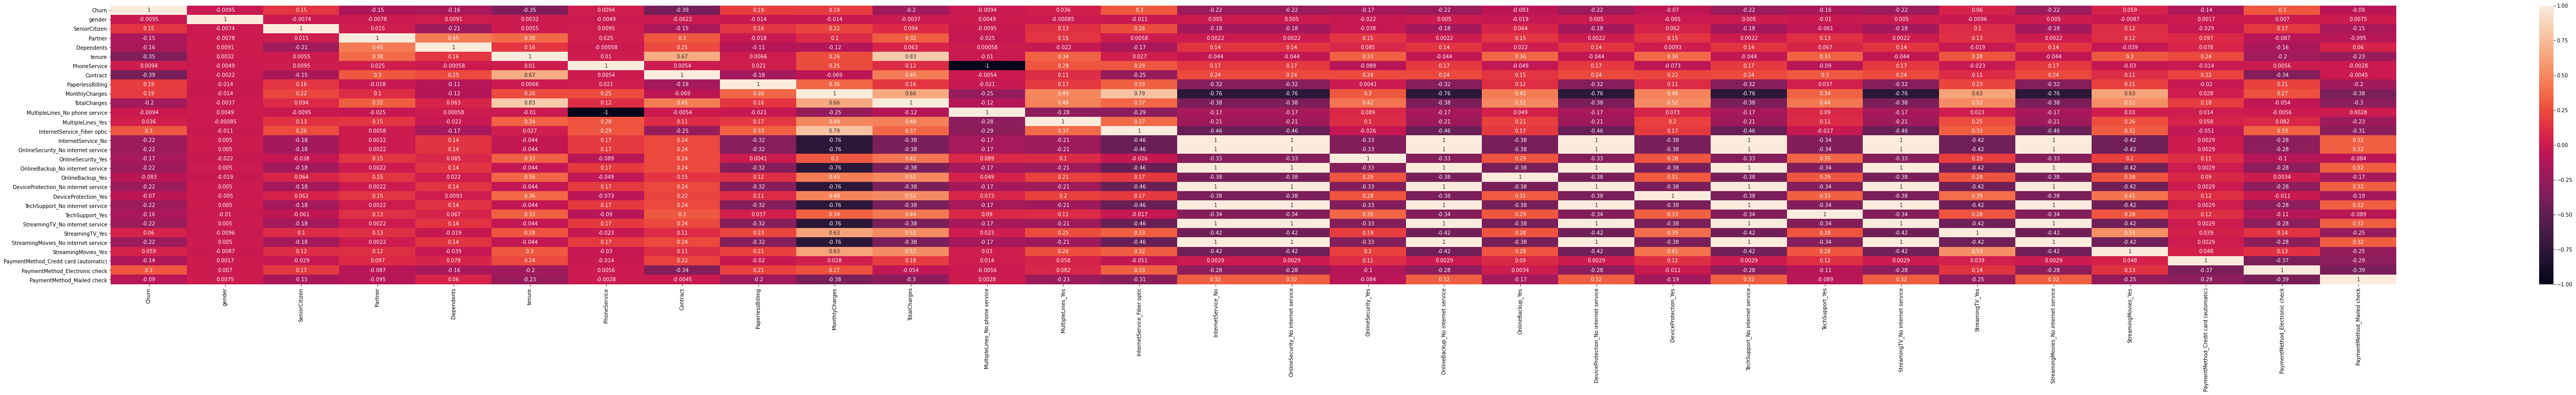

Columns of Strong interest: ['Churn', 'tenure', 'Contract', 'InternetService_Fiber optic'] 

Columns of Weaker interest: ['Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'Contract', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingMovies_No internet service', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check'] 



In [5]:
#correlate the dataframe pairwise to see which columns might be useful
corr=df.corr()

#plot the correlation to visualize the column pairings
plt.figure(figsize=(100,10))
sns.heatmap(corr, annot=True)
plt.show()

#Asolute values > .1 will be considered in our 
print(f"Columns of Strong interest: {corr[abs(corr['Churn']) > .3].index.tolist()} \n")
print(f"Columns of Weaker interest: {corr[abs(corr['Churn']) > .1].index.tolist()} \n")

<h2>Observations from the pair-wise correlation</h2>

Looking at the columns of Strong and Weaker Interest, we can safely remove 'Churn' as that is our target variable. Among the items of Strong Interest:

* I am surprised to see a strong correlation between 'InternetService_fiber optic' and Churn. Looking a little closer at the values we find a concurrance of ~63% which is pretty close to with randomly distributing the three possible variables through the dataset. Given the large number of 1's and 0's in this column, it is not likely a strong indicator

* Tenure is encoded to represent months as a Customer as in integer. It won't suffer from the same issue 'InternetService_fiber optic' did and will be a good column to use in our machine learning endeavours. 

* Contract was refigured to use 1 for 'Month-to-Month', 12 for 'One year', and 24 for 'Two year'. Fully 54% of all contracts are monthly, resulting in a '1' in that row's value. For the who dataframe, ~27% of all rows positively Churn. Doing some quick math: .54 * .27 == ~.15 expected if 'Churn' occurred randomly within Contract. Since absolute pairwise value is .39, we will use this column in our work.

I am not certain that using dummy variables was the correct approach for all columns. Perhaps it would have been better to encode them with a number value in their original column and not take this approach. Depending on the results I may come back and try a different approach. For now, I am going to use the columns 'Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'Contract', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingMovies_No internet service', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check' for my machine learning. 


<h2>Creating Test and Training data</h2>

Note, for consistencies sake, we will set random_state=42 where possible.

In [6]:
#Creating X and y
data_df=df[['Churn', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'Contract', 'PaperlessBilling', \
           'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'InternetService_No', \
           'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', \
           'DeviceProtection_No internet service', 'TechSupport_No internet service', 'TechSupport_Yes', \
           'StreamingTV_No internet service', 'StreamingMovies_No internet service', 'PaymentMethod_Credit card (automatic)',\
           'PaymentMethod_Electronic check']]
y=data_df['Churn']
X=data_df.drop(['Churn'], axis=1)

#Making sure the sizes remain consistent
if (X.shape[0] != y.shape[0]):
    print("Something is not right. The length of X and y are not the same")
else:
    print("Lengths match, we can continue")

#Creating the test and training data. We should be able to repeatedly do this in subsequent cells. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

Lengths match, we can continue


<h2>Models and Measuring Their Performance</h2>

For this classification problem, I referred to Jason Brownlee's blog article <a href='https://machinelearningmastery.com/types-of-classification-in-machine-learning/'>4 Tyoes of Classification Tasks in Machine Learning</a> to determine which models to implement. In the article, Jason specifically mentions Logistic Regression, k-Nearest Neighbors, Decision Trees, Support Vector Machine, and Naive Bayes as good candiates for this. For this exercise, I will implement all of these models and add Linear Regression and then evaluate these models against one another to determine which is the best fit for our problem. 

<b>Note, when looking at the Classification Report, 0 refers to False and 1 refers to True.<b> If you want to see them as True/False,  you need to un-comment the line casting values to Booleans. This line is commented so they remain as ints. Without this, the bonus model at the bottom will not work. 

<h3>Linear Regression</h3>

This is not a great choice for our Classification Problem. My main reason for implementing it here is because it is generally the first model most people implement. It is such a classic Machine Learning technique I feel compelled to add it.

In [7]:
#Instantiate the model
lin_clas=LinearRegression()

#Fit the model
lin_clas.fit(X_train, y_train)

#Get predicted values from X_test
lin_predicts=lin_clas.predict(X_test)

#Evaluate the model
print(f'r2_score: {r2_score(y_test, lin_predicts)}')

r2_score: 0.2805578490356557


<h4>Linear Regression Results:</h4>

With an r2_score of only ~.24, Linear Regression is not working well as expected. A perfect model would produce a result of 1.0. A model which always predicted the mean would produce a result of 0.0. While not good, our model is better than a coin-flip and we could possibly improve it by removing some of the columns used to limit the number of possible confounding variables. Setting aside how poorly suited Linear Regression is for our Classification problem, Linear Regression was not likely to be a good model without some additional work due to the imbalanced nature of the data. Any explanation of why imbalanced data is a poor basis for Linear Regression and some techniques for handling this problem can be found in <a href='https://towardsdatascience.com/regression-for-imbalanced-data-with-application-edf93517247c'>Regression for Imbalanced Data with Application</a> from the <b>towards data science</b> blog. 

<b>Linear Regression should likely be discarded as a model unless addition work done to handle the ublanaced data, and even then, it is ill suited for the work we are trying here. But it was fun to do.</b>

<h3>Test Function:</h3>
A lot of the code for testing these modules is retitive. This abstracts all of that away

In [12]:
def test_classifier(clas, X_train, y_train, X_test, y_test):
    '''
    Generic test to cut down on repetitive code 
    Inputs:
    clas - Instantiated classifier
    X_train, y_train, X_test, y_test - output from train_test_split for fitting and evaluating
    
    Output: None
    '''
    #Fit the model
    clas.fit(X_train, y_train)
    # Train the model
    y_predicts = clas.predict(X_test)
    
    # Evaluate and output reports
    print(f'Classification report for: {clas.__class__.__name__} \n \n {classification_report(y_test, y_predicts)} \n')
    # metrics.plot_confusion_matrix(clas, X_test, y_test, normalize='true')
    metrics.plot_confusion_matrix(clas, X_test, y_test)
    metrics.plot_roc_curve(clas, X_test, y_test)
    print(f'Params: {clas.get_params()} \n')
    return

<h3>Logistic Regression</h3>

This model is specifically built to handle a binary classification problem.

Classification report for: LogisticRegression 
 
               precision    recall  f1-score   support

           0       0.90      0.74      0.81       867
           1       0.53      0.79      0.64       331

    accuracy                           0.75      1198
   macro avg       0.72      0.76      0.72      1198
weighted avg       0.80      0.75      0.76      1198
 

Params: {'C': 1.01, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 24, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 



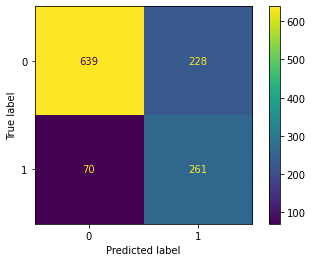

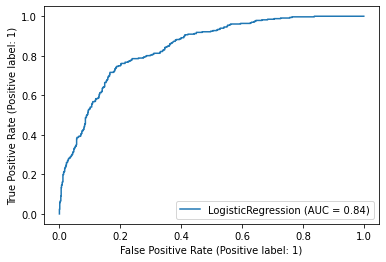

In [43]:
#Sending this to the test function to get our results
#
test_classifier(LogisticRegression(solver='lbfgs', max_iter=10000, random_state=24),
               X_train, y_train, X_test, y_test)

<h4>Logistic Regression Results:</h4>

To better understand the Classification report, please refer to <a href='https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397'>Understanding a Classification Report For Your Machine Learning Model</a>. 

We know from our initial analysis about 27% of the data is positive for Churn. If our model just predicted "No Churn" we would expect a 73% percision in the <b>False</b> line so our predictor's precision of 86% is <b>much better</b> than that. If our classifier simply chose "Churn", we would expect a percision of 27% in the <b>True</b> line and our actual percision is 65%, <b>more than double</b> the chance of always guessing 'Churn'. I did compare the output across multiple solvers, specifically lgfgs, sag, saga, newton-cg. The lbfgs is represented here as it had the best overall score edging out newton-cgs by a very slight margin. 

For those needing help to read a Confusion Matrix please see <a href='https://towardsdatascience.com/understanding-the-confusion-matrix-and-how-to-implement-it-in-python-319202e0fe4d'>Understanding the Confusion Matrix and How to Implement it in Python</a> from the <b>towards data science</b> blog. This image is taken from that article:
<img src='https://miro.medium.com/max/2400/1*n2im9rDJdRQMBNZ3pPMKXw.png'>
    
Comparing this to our confusion matrix here helps us to see our False Negative and False Positive rates have room for improvement. Given the accuracy of our model is already around 80%, I am going to leave it here for now and see what the preformance of a couple of other model are before attempting to improve this one.
    
Further tuning the weights of the parameters could push the performance of this from the default values. 

<h3>Support Vector Machine</h3>

This model is specifically built to handle binary classification. I used <a href='https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python'>Support Vector Machines with Scikit-learn</a> as a reference for the creation of this model.  

Classification report for: SVC 
 
               precision    recall  f1-score   support

           0       0.77      0.96      0.85       867
           1       0.70      0.25      0.37       331

    accuracy                           0.76      1198
   macro avg       0.74      0.61      0.61      1198
weighted avg       0.75      0.76      0.72      1198
 

Params: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False} 



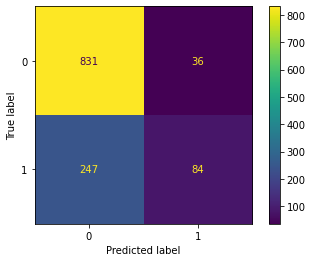

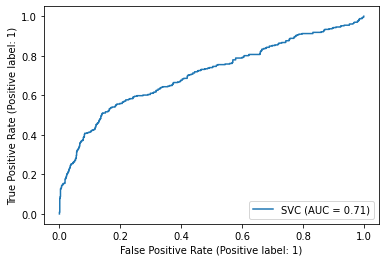

In [28]:
# Sending to the test function to get our results
test_classifier(svm.SVC(gamma='auto'),
               X_train, y_train, X_test, y_test)

<h4>Support Vector Machine Results</h4>

With the defalut parapmeters, this model predicted all cases as False. To solve this, I tried several things:

* I tried kernel='linear' but this ran for more than 30 minutes before I stopped it. I then tried LinearSVC but with max_iter=250000 the model still did not converge. 

* I tried kernel='poly' but got the same results. 

* After digging around in the reference API documents, I found the gamma setting and began to play with it. Setting it to gamma='auto' provided the results presented here. After changing gamma=auto, I tried running kernel='poly' again but the exectution time was not acceptable (still hadn't returned after 10 minutes).

* This model could be further tuned by tuning the gamma and Regularization parameters (C) to possibly improve the model. 

As was stated earlier, If our model just predicted "No Churn" we would expect a 73% percision in the <b>False</b> line so our predictor's precision of 77% is <b>marginally better </b> than that. If our classifier simply chose "Churn", we would expect a percision of 27% in the <b>True</b> line and our actual percision is 70%, <b>more than double</b> the chance of always guessing 'Churn' and even better than the Logistical Regression result. The recall performace for the True case is less than half of the recall for the Logistical Regression giving that model an edge over this one. 

<h3>Decision Tree</h3>

Classification report for: DecisionTreeClassifier 
 
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       867
           1       0.52      0.53      0.52       331

    accuracy                           0.74      1198
   macro avg       0.67      0.67      0.67      1198
weighted avg       0.74      0.74      0.74      1198
 



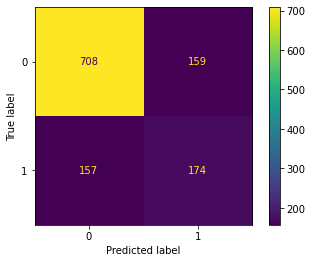

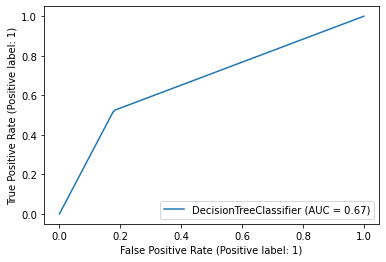

In [24]:
# Sending to the test function to get our results
test_classifier(tree.DecisionTreeClassifier(class_weight='balanced'),
               X_train, y_train, X_test, y_test)

<h4>Decision Tree Results</h4>

As was stated earlier, If our model just predicted "No Churn" we would expect a 73% percision in the <b>False</b> line so our predictor's precision of 82% is <b>better </b> than that. If our classifier simply chose "Churn", we would expect a percision of 27% in the <b>True</b> line and our actual percision is 53%, <b>nearly double</b> the chance of always guessing 'Churn'. While it is a decent model, it is not the best we have developed in this exercise. 

<h3>K Nearest Neighbors</h3>

This will be a two-step process. First we must evaluate the KNN model across multiple k values to see which is best. We will use accuracy for this first pass. 

Text(0, 0.5, 'Test Accuracy')

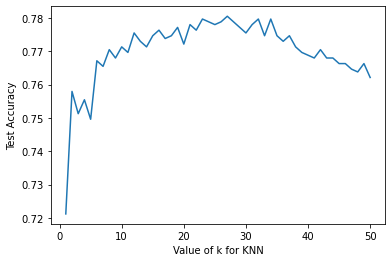

In [13]:
k_range=range(1,51)
scores={}
scores_list=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred=knn.predict(X_test)
    scores[k]=metrics.accuracy_score(y_test, y_pred)
    scores_list.append(metrics.accuracy_score(y_test, y_pred))
    
plt.plot(k_range, scores_list)
plt.xlabel('Value of k for KNN')
plt.ylabel('Test Accuracy')

Looking at the graph, we can see the model maxes out somewhere around k=26. We will now build a model with k=25-27 to identify which model has the best results and evaluate this against our other models. 

Classification report for: KNeighborsClassifier 
 
               precision    recall  f1-score   support

           0       0.80      0.94      0.86       867
           1       0.69      0.38      0.49       331

    accuracy                           0.78      1198
   macro avg       0.74      0.66      0.67      1198
weighted avg       0.77      0.78      0.76      1198
 



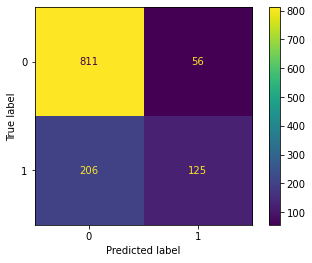

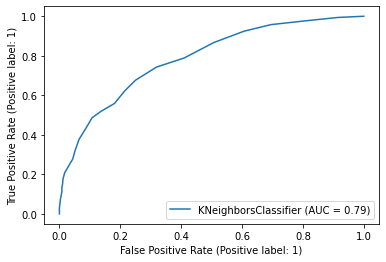

In [29]:
# Sending to the test function to get our results
test_classifier(KNeighborsClassifier(n_neighbors=27, algorithm='ball_tree'),
               X_train, y_train, X_test, y_test)

<h4>K Nearest Neighbors Results</h4>

As was stated earlier, If our model just predicted "No Churn" we would expect a 73% percision in the <b>False</b> line so our KNN's precision of 80% is <b>better</b> than that. If our classifier simply chose "Churn", we would expect a percision of 27% in the <b>True</b> line and our actual percision is 63%, <b>more than double</b> the chance of always guessing 'Churn'. Again, this model is not bad and does seem to work, just not as good as our Logistical Regression Model did. 

<h3>Naive Bayes</h3>

Classification report for: GaussianNB 
 
               precision    recall  f1-score   support

           0       0.92      0.58      0.71       867
           1       0.44      0.86      0.58       331

    accuracy                           0.66      1198
   macro avg       0.68      0.72      0.65      1198
weighted avg       0.79      0.66      0.68      1198
 



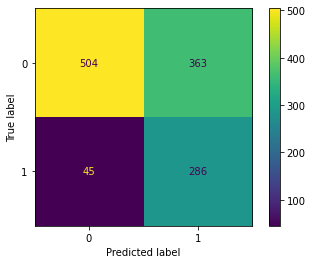

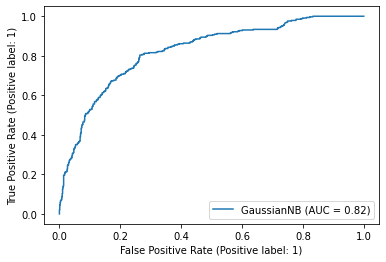

In [15]:
# Sending to the test function to get our results
test_classifier(GaussianNB(),
               X_train, y_train, X_test, y_test)

<h4>Naive Bayes Results</h4>

As was stated earlier, If our model just predicted "No Churn" we would expect a 73% percision in the <b>False</b> line so our KNN's precision of 92% is <b>much better</b> than that. If our classifier simply chose "Churn", we would expect a percision of 27% in the <b>True</b> line and our actual percision is 44%, <b>better than</b> the chance of always guessing 'Churn'. While those numbers look good, the confusion matrix tells us this model suffers from an indordinate amount of False positives. With an overall f1 score of 66% it is the lowest evaluated model we have made here. Based on this and the confusion matrix, there are likely better choices depending on the parameters of the question. 

<h3>Keras Nueral Network</h3>

Add this here just to do it. This model is not part of my discussion above. It is only added for comparison. The model.fit method can take some time to execute. On my PC, it can take as much as 30 seconds. It seems like an epoch when waiting :)

38/38 [==============================] - 0s 534us/step - loss: 0.1406 - accuracy: 0.7988
Loss and Metrics: [0.14057812094688416, 0.7988314032554626] 

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.53      0.68       867
           1       0.43      0.93      0.59       331

    accuracy                           0.64      1198
   macro avg       0.69      0.73      0.64      1198
weighted avg       0.81      0.64      0.66      1198
 

Confusion matrix: 
 [[462 405]
 [ 22 309]] 



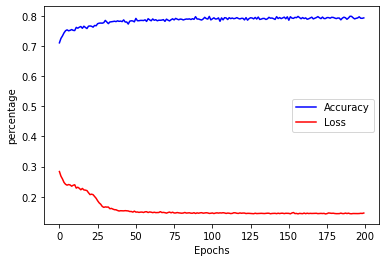

In [16]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout

#Instantiate the model
model = Sequential([
    Dense(32, activation='softplus', input_dim=20),
    Dropout(0.5),
    Dense(16, activation='softplus'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])

#Fit the model
history = model.fit(X_train, y_train, batch_size=10, epochs=200,verbose=0)

#Evaluate the Model
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=32)
print(f'Loss and Metrics: {loss_and_metrics} \n')

#This is how we have evaluated all the other models. To use this, we must first get the predicts and then 
#transfor the predicts into zeroes and ones. 
model_predicts=model.predict(X_test)
model_predicts=[1 if y>=.05 else 0 for y in model_predicts]
print(f'Classification report: \n {classification_report(y_test, model_predicts, zero_division=0)} \n')
print(f'Confusion matrix: \n {confusion_matrix(y_test, model_predicts)} \n')

#This plot is of the model itself. Note we can't use roc_curve here so this is different. 
plt.plot(history.history['accuracy'], label='Accuracy', color='blue')
plt.plot(history.history['loss'], label='Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("percentage")
plt.legend()
plt.show()

<h4>Keras Neural Network Results</h4>

As was stated earlier, If our model just predicted "No Churn" we would expect a 73% percision in the <b>False</b> line so our Keras precision of 92% is <b>better</b> than that. If our classifier simply chose "Churn", we would expect a percision of 27% in the <b>True</b> line and our actual percision is 44%, <b>better than</b> the simple chance of always guessing 'Churn'. A closer look at the Classification report however shows this model has some issues. While it's predictions of "False" are very accurate at 92%, the model on catches 58% of ALL False rows in the test data. The precision on True is not very good--yielding a lot of False positives as shown in the Confusion Matrix--it is however very good at catching 86% of ALL True rows in the test data.